# Introduction
- nb29 で使いまわすfcを作成するため、ここで一度、ハイパーパラメータを決めたいと思う
- nb27の特徴量を使用する

# Import everything I need :)

In [1]:
import time
import multiprocessing
import glob
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from functools import partial
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from fastprogress import progress_bar

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# Preparation

In [2]:
nb = 28
isSmallSet = False
length = 10000

In [3]:
pd.set_option('display.max_columns', 100)

In [4]:
file_path = '../input/champs-scalar-coupling/'
glob.glob(file_path + '*')

['../input/champs-scalar-coupling/sample_submission.csv',
 '../input/champs-scalar-coupling/potential_energy.csv',
 '../input/champs-scalar-coupling/train.csv',
 '../input/champs-scalar-coupling/scalar_coupling_contributions.csv',
 '../input/champs-scalar-coupling/structures.csv',
 '../input/champs-scalar-coupling/test.csv',
 '../input/champs-scalar-coupling/magnetic_shielding_tensors.csv',
 '../input/champs-scalar-coupling/dipole_moments.csv',
 '../input/champs-scalar-coupling/mulliken_charges.csv']

In [5]:
# train
path = file_path + 'train.csv'
if isSmallSet:
    train = pd.read_csv(path) [:length]
else:
    train = pd.read_csv(path)

In [6]:
# test
path = file_path + 'test.csv'
if isSmallSet:
    test = pd.read_csv(path)[:length]
else:
    test = pd.read_csv(path)

In [7]:
# structure
path = file_path + 'structures.csv'
structures = pd.read_csv(path)

In [8]:
if isSmallSet:
    print('using SmallSet !!')
    print('-------------------')

print(f'There are {train.shape[0]} rows in train data.')
print(f'There are {test.shape[0]} rows in test data.')

print(f"There are {train['molecule_name'].nunique()} distinct molecules in train data.")
print(f"There are {test['molecule_name'].nunique()} distinct molecules in test data.")
print(f"There are {train['atom_index_0'].nunique()} unique atoms.")
print(f"There are {train['type'].nunique()} unique types.")

There are 4658147 rows in train data.
There are 2505542 rows in test data.
There are 85003 distinct molecules in train data.
There are 45772 distinct molecules in test data.
There are 29 unique atoms.
There are 8 unique types.


---
## myFunc
**metrics**

In [9]:
def kaggle_metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)

---
**momory**

In [10]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Feature Engineering

**basic**

In [11]:
def map_atom_info(df_1,df_2, atom_idx):
    df = pd.merge(df_1, df_2, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    df = df.drop('atom_index', axis=1)

    return df


for atom_idx in [0,1]:
    train = map_atom_info(train, structures, atom_idx)
    test  = map_atom_info(test, structures, atom_idx)
    
    train = train.rename(columns={'atom': f'atom_{atom_idx}',
                                        'x': f'x_{atom_idx}',
                                        'y': f'y_{atom_idx}',
                                        'z': f'z_{atom_idx}'})
    test  =  test.rename(columns={'atom': f'atom_{atom_idx}',
                                        'x': f'x_{atom_idx}',
                                        'y': f'y_{atom_idx}',
                                        'z': f'z_{atom_idx}'})

distances

`type` の特徴量から、数字を抽出  
例) 2JHC ---> 2

In [12]:
train['type_0'] = train['type'].apply(lambda x: x[0])
test['type_0'] = test['type'].apply(lambda x: x[0])

add angle features
- angle featue を追加するためには、dist が必要

In [13]:
# dist
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
train['dist_x'] = (train['x_0'] - train['x_1']) ** 2
test['dist_x'] = (test['x_0'] - test['x_1']) ** 2
train['dist_y'] = (train['y_0'] - train['y_1']) ** 2
test['dist_y'] = (test['y_0'] - test['y_1']) ** 2
train['dist_z'] = (train['z_0'] - train['z_1']) ** 2
test['dist_z'] = (test['z_0'] - test['z_1']) ** 2

train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 630.81 Mb (11.2% reduction)
Mem. usage decreased to 320.19 Mb (11.8% reduction)


In [14]:
def add_cos_features(df):
    #I apologize for my poor coding skill. Please make the better one.
#     print(train.shape)
    df_temp=df.loc[:,["molecule_name","atom_index_0","atom_index_1","dist","x_0","y_0","z_0","x_1","y_1","z_1"]].copy()

    df_temp_=df_temp.copy()
    df_temp_= df_temp_.rename(columns={'atom_index_0': 'atom_index_1',
                                       'atom_index_1': 'atom_index_0',
                                       'x_0': 'x_1',
                                       'y_0': 'y_1',
                                       'z_0': 'z_1',
                                       'x_1': 'x_0',
                                       'y_1': 'y_0',
                                       'z_1': 'z_0'})
    df_temp=pd.concat((df_temp,df_temp_),axis=0)
    df_temp["min_dist"]=df_temp.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df_temp= df_temp[df_temp["min_dist"]==df_temp["dist"]]
    df_temp=df_temp.drop(['x_0','y_0','z_0','min_dist'], axis=1)
    df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                     'atom_index_1': 'atom_index_closest',
                                     'dist': 'dist_closest',
                                     'x_1': 'x_closest',
                                     'y_1': 'y_closest',
                                     'z_1': 'z_closest'})

    #delete duplicated rows (some atom pairs have perfectly same distance)
    #This code is added based on Adriano Avelar's comment.
    df_temp=df_temp.drop_duplicates(subset=['molecule_name', 'atom_index'])

    for atom_idx in [0,1]:
        df = map_atom_info(df,df_temp, atom_idx)
        df = df.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
                                            'dist_closest': f'dist_closest_{atom_idx}',
                                            'x_closest': f'x_closest_{atom_idx}',
                                            'y_closest': f'y_closest_{atom_idx}',
                                            'z_closest': f'z_closest_{atom_idx}'})

    df["dist_0"]=((df['x_0']-df['x_closest_0'])**2+(df['y_0']-df['y_closest_0'])**2+(df['z_0']-df['z_closest_0'])**2)**(1/2)
    df["dist_1"]=((df['x_1']-df['x_closest_1'])**2+(df['y_1']-df['y_closest_1'])**2+(df['z_1']-df['z_closest_1'])**2)**(1/2)
    df["vec_0_x"]=(df['x_0']-df['x_closest_0'])/df["dist_0"]
    df["vec_0_y"]=(df['y_0']-df['y_closest_0'])/df["dist_0"]
    df["vec_0_z"]=(df['z_0']-df['z_closest_0'])/df["dist_0"]
    df["vec_1_x"]=(df['x_1']-df['x_closest_1'])/df["dist_1"]
    df["vec_1_y"]=(df['y_1']-df['y_closest_1'])/df["dist_1"]
    df["vec_1_z"]=(df['z_1']-df['z_closest_1'])/df["dist_1"]
    df["vec_x"]=(df['x_1']-df['x_0'])/df["dist"]
    df["vec_y"]=(df['y_1']-df['y_0'])/df["dist"]
    df["vec_z"]=(df['z_1']-df['z_0'])/df["dist"]
    df["cos_0_1"]=df["vec_0_x"]*df["vec_1_x"]+df["vec_0_y"]*df["vec_1_y"]+df["vec_0_z"]*df["vec_1_z"]
    df["cos_0"]=df["vec_0_x"]*df["vec_x"]+df["vec_0_y"]*df["vec_y"]+df["vec_0_z"]*df["vec_z"]
    df["cos_1"]=df["vec_1_x"]*df["vec_x"]+df["vec_1_y"]*df["vec_y"]+df["vec_1_z"]*df["vec_z"]
    df=df.drop(['vec_0_x','vec_0_y','vec_0_z','vec_1_x','vec_1_y','vec_1_z','vec_x','vec_y','vec_z'], axis=1)
    
    df = reduce_mem_usage(df)
    
    return df

train = add_cos_features(train)
test  = add_cos_features(test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




Mem. usage decreased to 1101.70 Mb (0.0% reduction)
Mem. usage decreased to 573.47 Mb (0.0% reduction)


---
LabelEncode
- `atom_1` = {H, C, N}
- `type_0` = {1, 2, 3}
- `type`   = {2JHC, ...}

In [15]:
for f in ['atom_1', 'type_0', 'type']:
    if f in train.columns:
        lbl = LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))

---
**show features**

In [16]:
train.head(2)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,type_0,dist,dist_x,dist_y,dist_z,atom_index_closest_0,dist_closest_0,x_closest_0,y_closest_0,z_closest_0,atom_index_closest_1,dist_closest_1,x_closest_1,y_closest_1,z_closest_1,dist_0,dist_1,cos_0_1,cos_0,cos_1
0,0,dsgdb9nsd_000001,1,0,0,84.8076,H,0.00215,-0.006031,0.001976,0,-0.012698,1.085804,0.008001,0,1.091953,0.000220,1.192105,0.000036,0,1.091953,-0.012698,1.085804,0.008001,3,1.091946,-0.540815,1.447527,-0.876644,1.091953,1.091946,0.333335,-1.000000,-0.333335
1,1,dsgdb9nsd_000001,1,2,3,-11.2570,H,0.00215,-0.006031,0.001976,1,1.011731,1.463751,0.000277,1,1.783120,1.019253,2.160261,0.000003,0,1.091953,-0.012698,1.085804,0.008001,0,1.091952,-0.012698,1.085804,0.008001,1.091953,1.091952,-0.333287,-0.816483,0.816482


In [17]:
print(train.columns)

Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant', 'atom_0', 'x_0', 'y_0', 'z_0', 'atom_1',
       'x_1', 'y_1', 'z_1', 'type_0', 'dist', 'dist_x', 'dist_y', 'dist_z',
       'atom_index_closest_0', 'dist_closest_0', 'x_closest_0', 'y_closest_0',
       'z_closest_0', 'atom_index_closest_1', 'dist_closest_1', 'x_closest_1',
       'y_closest_1', 'z_closest_1', 'dist_0', 'dist_1', 'cos_0_1', 'cos_0',
       'cos_1'],
      dtype='object')


# create train, test data

In [22]:
# train = reduce_mem_usage(train)
# test  = reduce_mem_usage(test)
y = train['scalar_coupling_constant']
train = train.drop(['id', 'molecule_name', 'atom_0', 'scalar_coupling_constant'], axis=1)
test  =  test.drop(['id', 'molecule_name', 'atom_0'], axis=1)

X = train.copy()
X_test = test.copy()

In [23]:
del train, test

In [24]:
gc.collect()

145

# Hyperopt

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                  y,
                                                  test_size = 0.10, 
                                                  random_state = 0)

In [26]:
N_JOBS = multiprocessing.cpu_count() -1

In [27]:
# Define searched space
hyper_space = {'objective': 'regression',
               'metric':'mae',
               'boosting':'gbdt',
               'max_depth':  hp.choice('max_depth', [5, 8, 10, 12, 15]),
               'num_leaves': hp.choice('num_leaves', [100, 250, 500, 650, 750, 1000,1300]),
               'subsample': hp.choice('subsample', [.3, .5, .7, .8, 1]),
               'colsample_bytree': hp.choice('colsample_bytree', [ .6, .7, .8, .9, 1]),
               'learning_rate': hp.choice('learning_rate', [.1, .2, .3]),
               'reg_alpha': hp.choice('reg_alpha', [.1, .2, .3, .4, .5, .6]),
               'reg_lambda':  hp.choice('reg_lambda', [.1, .2, .3, .4, .5, .6]),               
               'min_child_samples': hp.choice('min_child_samples', [20, 45, 70, 100])}

In [28]:
# lgtrain = lightgbm.Dataset(X_train, label=y_train)
# lgval = lightgbm.Dataset(X_val, label=y_val)

def evaluate_metric(params):
#     model_lgb = lgb.train(params, lgtrain, 500, 
#                           valid_sets=[lgtrain, lgval], early_stopping_rounds=20, 
#                           verbose_eval=500)
#     model_lgb = lgb.train(para)
    model_lgb = lgb.LGBMRegressor(**params, n_jobs=N_JOBS, n_estimators=500) 
    model_lgb.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              verbose=500,
              early_stopping_rounds=100)

    pred = model_lgb.predict(X_valid)

    _X_valid = X_valid.copy()
    _X_valid['scalar_coupling_constant'] = y_valid
    cv_score = kaggle_metric(_X_valid, pred)
    _X_valid = _X_valid.drop(['scalar_coupling_constant'], axis=1)
    
    print(cv_score)
 
    return {
        'loss': cv_score,
        'status': STATUS_OK,
        'stats_running': STATUS_RUNNING
    }

In [29]:
# Trail
trials = Trials()

# Set algoritm parameters
algo = partial(tpe.suggest, 
               n_startup_jobs=-1)

# Seting the number of Evals
MAX_EVALS= 15

# Fit Tree Parzen Estimator
best_vals = fmin(evaluate_metric, space=hyper_space, verbose=1,
                 algo=algo, max_evals=MAX_EVALS, trials=trials)

# Print best parameters
best_params = space_eval(hyper_space, best_vals)

Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 1.24532	valid_1's l1: 1.31382  
Did not meet early stopping. Best iteration is:     
[500]	training's l1: 1.24532	valid_1's l1: 1.31382
0.04793745425817021                                 
Training until validation scores don't improve for 100 rounds.                 
[500]	training's l1: 1.24532	valid_1's l1: 1.31382                             
Did not meet early stopping. Best iteration is:                                
[500]	training's l1: 1.24532	valid_1's l1: 1.31382
0.047937454258083045                                                           
Training until validation scores don't improve for 100 rounds.                  
[500]	training's l1: 1.53533	valid_1's l1: 1.54594                              
Did not meet early stopping. Best iteration is:                                 
[500]	training's l1: 1.53533	valid_1's l1: 1.54594
0.22572136799147563                                           

In [30]:
print("BEST PARAMETERS: " + str(best_params))

BEST PARAMETERS: {'boosting': 'gbdt', 'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 15, 'metric': 'mae', 'min_child_samples': 20, 'num_leaves': 1300, 'objective': 'regression', 'reg_alpha': 0.6, 'reg_lambda': 0.6, 'subsample': 0.7}


In [31]:
del X_train, X_valid, y_train, y_valid
gc.collect()

3126

---

# Training model with the optimized params
- この結果と比較するのであれば、hypyeroptを使用していない、nb27だろう

**params**

In [34]:
# Configuration
TARGET = 'scalar_coupling_constant'
# CAT_FEATS = ['type']
N_ESTIMATORS = 1500
VERBOSE = 300
EARLY_STOPPING_ROUNDS = 200
RANDOM_STATE = 529
METRIC = mean_absolute_error
N_JOBS = multiprocessing.cpu_count() -1

# lightgbm params
lgb_params = {'num_leaves': 128,
          'min_child_samples': 20,
          'num_leaves': 1300,
          'objective': 'regression',
          'max_depth': 15,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.7,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.6,
          'reg_lambda': 0.6,
          'colsample_bytree': 0.7
         }


In [35]:
n_folds = 4
folds = KFold(n_splits=n_folds, shuffle=True)

In [36]:
# init

def train_lgb(X, X_test, y, lgb_params, folds,
              verbose, early_stopping_rounds, n_estimators):

    result_dict = {}
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    models = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X)):
        print('------------------')
        print(f'- fold{fold_n + 1}' )
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
#         from IPython.core.debugger import Pdb; Pdb().set_trace()
        

        # Train the model
        model = lgb.LGBMRegressor(**lgb_params, n_estimators=n_estimators, n_jobs=N_JOBS)
        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  verbose=verbose,
                  early_stopping_rounds=early_stopping_rounds)

        # predict
        y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration_)   
        y_test_pred = model.predict(X_test)

        oof[valid_idx] = y_valid_pred.reshape(-1,)  # oof: out of folds
        scores.append(mean_absolute_error(y_valid, y_valid_pred))

        prediction += y_test_pred

        # feature_importance
        fold_importance = pd.DataFrame()
        fold_importance['feature'] = X.columns
        fold_importance['importance'] = model.feature_importances_
        fold_importance['fold'] = fold_n + 1
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    # result
    prediction /= folds.n_splits
    feature_importance["importance"] /= folds.n_splits
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    result_dict['feature_importance'] = feature_importance


    print('------------------')
    print('====== finish ======')
    print('score list:', scores)
    X['scalar_coupling_constant'] = y
    cv_score = kaggle_metric(X, oof)
#     X = X.drop(['scalar_coupling_constant', 'prediction'], axis=1)
    print('CV mean score(group log mae): {0:.4f}'.format(cv_score))

    
    return result_dict, cv_score

In [37]:
# train
result_dict, cv_score = train_lgb(X=X, X_test=X_test, y=y, lgb_params=lgb_params, folds=folds,
                        verbose=VERBOSE, early_stopping_rounds=EARLY_STOPPING_ROUNDS, 
                        n_estimators=N_ESTIMATORS)

X = X.drop(['scalar_coupling_constant', 'prediction'], axis=1)

------------------
- fold1
Fold 1 started at Mon Jul 15 11:19:01 2019
Training until validation scores don't improve for 200 rounds.
[300]	training's l1: 0.92748	valid_1's l1: 1.16942
[600]	training's l1: 0.744423	valid_1's l1: 1.11457
[900]	training's l1: 0.624882	valid_1's l1: 1.08716
[1200]	training's l1: 0.536584	valid_1's l1: 1.06969
[1500]	training's l1: 0.466873	valid_1's l1: 1.05938
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.466873	valid_1's l1: 1.05938
------------------
- fold2
Fold 2 started at Mon Jul 15 11:31:16 2019
Training until validation scores don't improve for 200 rounds.
[300]	training's l1: 0.927307	valid_1's l1: 1.17627
[600]	training's l1: 0.742938	valid_1's l1: 1.11956
[900]	training's l1: 0.62335	valid_1's l1: 1.09258
[1200]	training's l1: 0.535669	valid_1's l1: 1.0765
[1500]	training's l1: 0.467011	valid_1's l1: 1.06589
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.467011	valid_1's l1: 1.06589
-----------

## plot feature importance

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



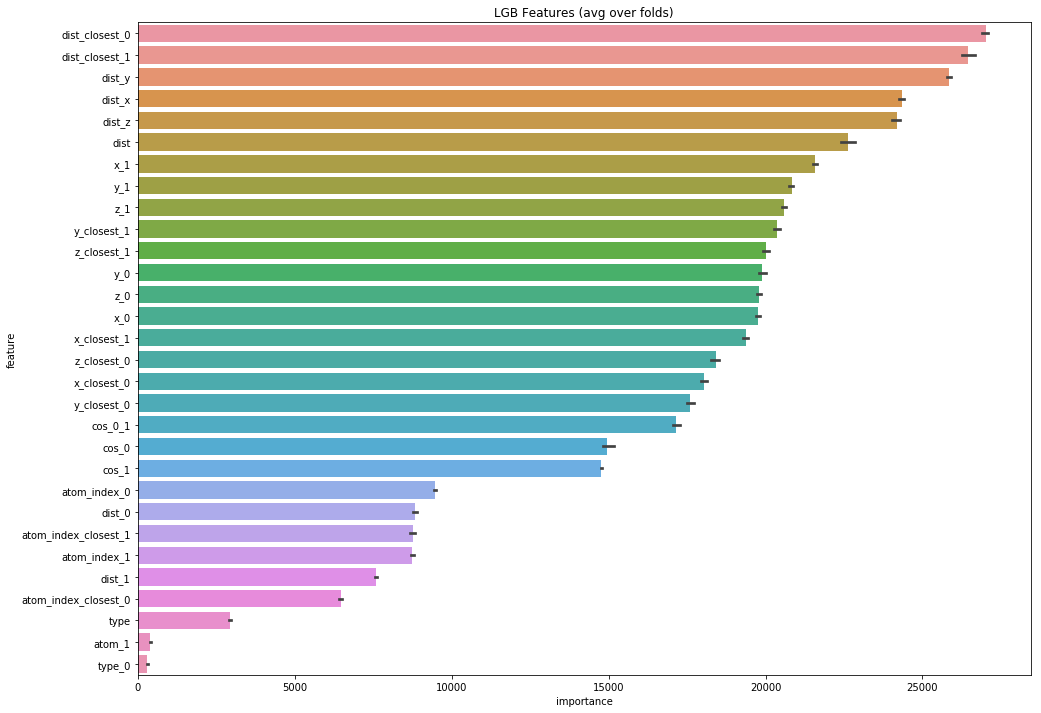

In [38]:
# top n features
top_n = 50

feature_importance = result_dict['feature_importance']
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:top_n].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');

# Save

**submission**

In [39]:
path_submittion = '../output/' + 'nb{}_submission_lgb_{}.csv'.format(nb, cv_score)
# path_submittion = 'nb{}_submission_lgb_{}.csv'.format(nb, cv_score)
print(f'save pash: {path_submittion}')

save pash: ../output/nb28_submission_lgb_-0.17362778625328787.csv


In [40]:
submittion = pd.read_csv('../input/champs-scalar-coupling/sample_submission.csv')
# submittion = pd.read_csv('./input/champs-scalar-coupling/sample_submission.csv')[:100]
submittion['scalar_coupling_constant'] = result_dict['prediction']
submittion.to_csv(path_submittion, index=False)

---
**result**

In [41]:
path_oof = '../output/' + 'nb{}_oof_lgb_{}.csv'.format(nb, cv_score)
print(f'save pash: {path_oof}')

save pash: ../output/nb28_oof_lgb_-0.17362778625328787.csv


In [42]:
oof = pd.DataFrame(result_dict['oof'])
oof.to_csv(path_oof, index=False)

# analysis

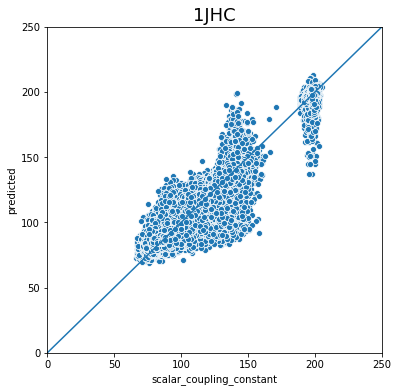

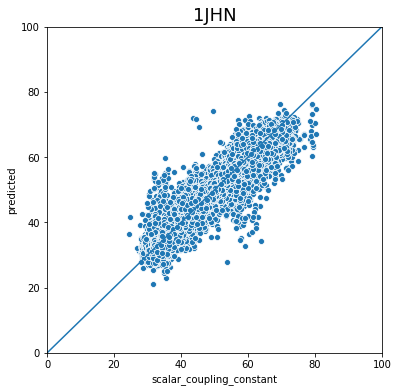

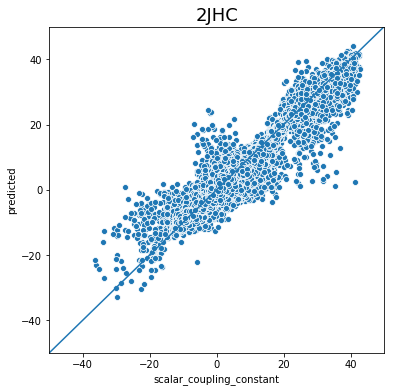

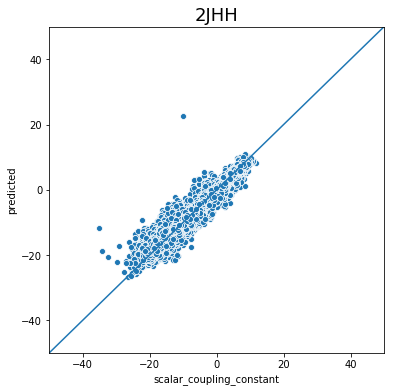

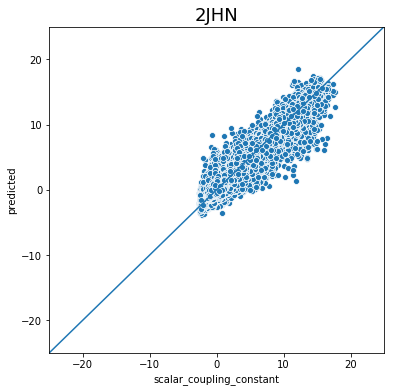

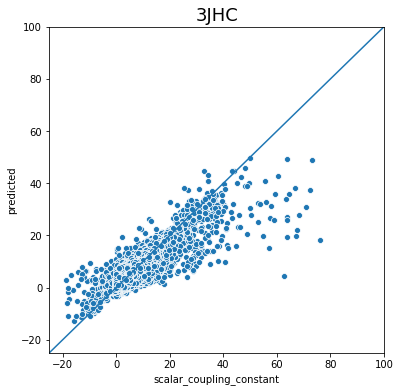

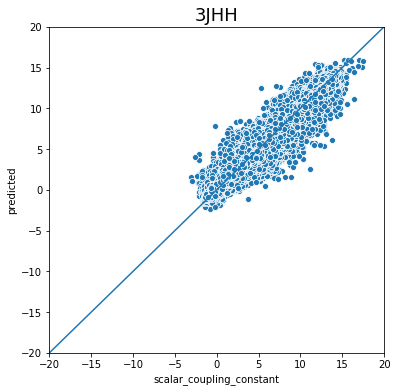

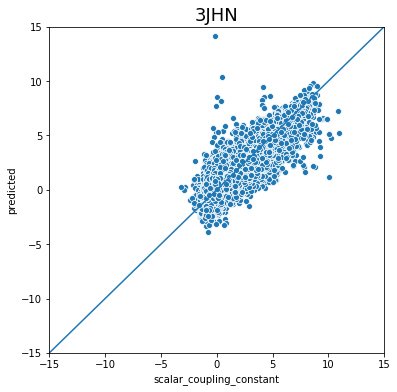

In [43]:
plot_data = pd.DataFrame(y)
plot_data.index.name = 'id'
plot_data['yhat'] = result_dict['oof']
plot_data['type'] = lbl.inverse_transform(X['type'])

def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='scalar_coupling_constant',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['scalar_coupling_constant', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('scalar_coupling_constant')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 50)
plot_oof_preds('2JHN', -25, 25)
plot_oof_preds('3JHC', -25, 100)
plot_oof_preds('3JHH', -20, 20)
plot_oof_preds('3JHN', -15, 15)